In [1]:
from my_forest_fire import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Number of examples: 3663
Number of label types: 49


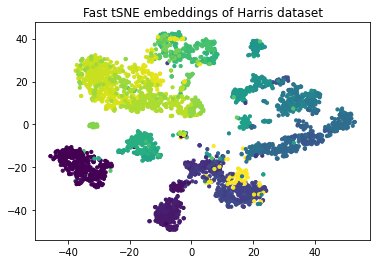

In [16]:
# Clusters Harris data
filename_data = 'Datasets/harris-plos/data.npy'
filename_gt = 'Datasets/harris-plos/clusters.npy'
filename_embeddings = 'Datasets/harris-plos/fast_tsne_embeddings.npy'

with open(filename_data, 'rb') as f1:
    harris_data = np.load(f1)
with open(filename_gt, 'rb') as f2:
    harris_gt = np.load(f2)
with open(filename_embeddings, 'rb') as f3:
    harris_embeddings = np.load(f3)

N_harris = harris_gt.shape[0]
print('Number of examples:', N_harris)
K_harris = np.unique(harris_gt).shape[0]
print('Number of label types:', K_harris)
plt.title('Fast tSNE embeddings of Harris dataset')
plt.scatter(harris_embeddings[:, 0], harris_embeddings[:, 1], c=harris_gt, s=10)
plt.show()

# harris_embeddings = StandardScaler().fit_transform(harris_embeddings)#Normalizes

# No need to take subset; N=3663 is relatively small already

In [17]:
# Computes affinity matrix
D_harris = compute_distance_matrix(harris_embeddings)
A_harris = compute_affinity_matrix(D_harris, k=10)


Model burnt 139 clusters. Reassigning 379 points to k=49 biggest clusters.


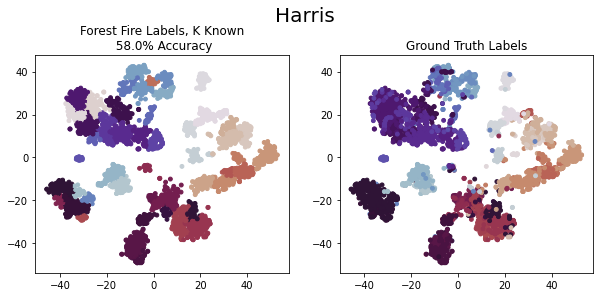

79 clusters are too small; reassigning the 239 points in them. Final model contains 60 clusters.


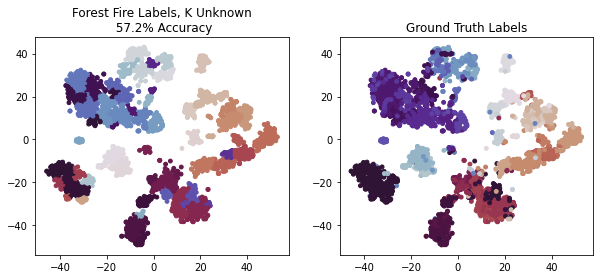

In [22]:
fire_temp_harris = 10

harris_labels_known = forest_fire_clustering(A_harris, fire_temp_harris, k=K_harris, n_before_break=100, verbose=True)
harris_aligned_known = align_labels(harris_gt, harris_labels_known)
display_outputs_and_gt(harris_embeddings, harris_gt, harris_aligned_known, k_known=True, title='Harris', compute_accuracy=True)

harris_labels_unknown = forest_fire_clustering(A_harris, fire_temp_harris, min_cluster_size=10, removal_threshold=.2, n_before_break=100, verbose=True)
harris_aligned_unknown = align_labels(harris_gt, harris_labels_unknown)
display_outputs_and_gt(harris_embeddings, harris_gt, harris_aligned_unknown, k_known=False, compute_accuracy=True)



Iteration 1/10. Time elapsed: 9.89 seconds
Iteration 2/10. Time elapsed: 18.78 seconds
Iteration 3/10. Time elapsed: 29.1 seconds
Iteration 4/10. Time elapsed: 39.12 seconds
Iteration 5/10. Time elapsed: 46.99 seconds
Iteration 6/10. Time elapsed: 56.14 seconds
Iteration 7/10. Time elapsed: 65.4 seconds
Iteration 8/10. Time elapsed: 73.72 seconds
Iteration 9/10. Time elapsed: 84.08 seconds


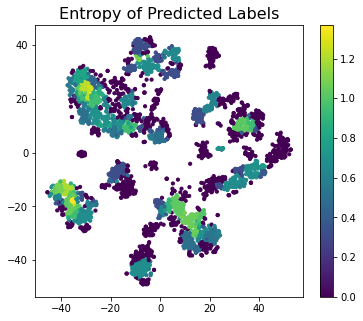

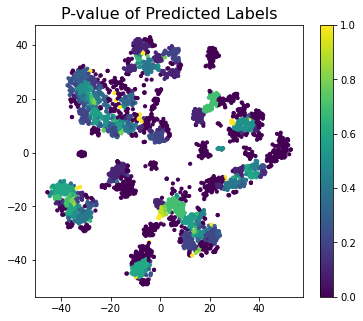

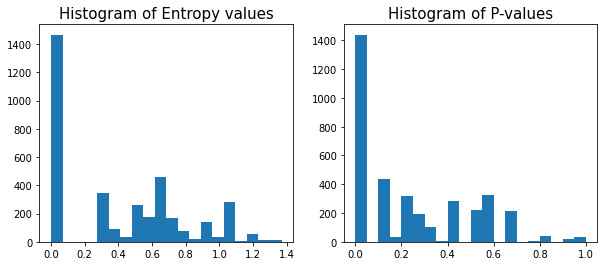

In [23]:
# Measures spread with Monte Carlo verification
monte_carlo_labels_harris = monte_carlo_verification(harris_aligned_known, A_harris, fire_temp_harris, num_permute=10)
# Colors/values give uncertainty estimate for each point
e_harris = display_entropy(monte_carlo_labels_harris, harris_embeddings, return_entropy=True, s=10)
p_harris = display_p_values(monte_carlo_labels_harris, harris_aligned_known, harris_embeddings, return_pvals=True, s=10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.set_title('Histogram of Entropy values', fontsize=15)
ax1.hist(e_harris, bins=20)

ax2.set_title('Histogram of P-values', fontsize=15)
ax2.hist(p_harris, bins=20)
plt.show()


In [25]:
unstable_idx_harris = np.argwhere(e_harris>0.2).reshape(-1)
print_alternate_clusters(harris_aligned_known, monte_carlo_labels_harris, unstable_idx_harris)


118 unstable points originally labeled in Cluster #0
  - 11% of different labelings to Cluster #1
  - 44% of different labelings to Cluster #7
  - 45% of different labelings to Cluster #29
--------------------
129 unstable points originally labeled in Cluster #1
  - 43% of different labelings to Cluster #7
  - 18% of different labelings to Cluster #29
  - 40% of different labelings to Cluster #35
--------------------
5 unstable points originally labeled in Cluster #3
  - 100% of different labelings to Cluster #4
--------------------
89 unstable points originally labeled in Cluster #4
  - 100% of different labelings to Cluster #3
--------------------
26 unstable points originally labeled in Cluster #5
  - 100% of different labelings to Cluster #47
--------------------
117 unstable points originally labeled in Cluster #6
  - 76% of different labelings to Cluster #5
  - 17% of different labelings to Cluster #10
  - 8% of different labelings to Cluster #47
--------------------
11 unstable 

orange, red, and silver


Unstable cluster shown in black.
In Monte Carlo, a point in it was frequently labeled in cluster shown in orange.
All other clusters shown in blue.


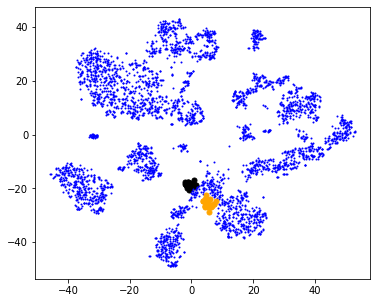

In [47]:
unstable_clusters, unstable_counts = np.unique(harris_aligned_known[unstable_idx], return_counts=True)
clusters, counts = np.unique(harris_aligned_known, return_counts=True)
most_unstable_cluster = unstable_clusters[np.argmax(counts)]

# Make plot of largest clusters and smaller clusters that map to it
in_largest = harris_aligned_known==most_unstable_cluster
unstable_idx = np.argwhere((e_harris > 0.2) & in_largest).reshape(-1)


# Gets all labels for an unstable point originally in largest cluster
pt = unstable_idx[harris_aligned_known[unstable_idx]==most_unstable_cluster][0]
perm_rows = monte_carlo_labels_harris[:,pt] != -1

cdict = {0: 'orange', 1: 'red', 2: 'silver', 3: 'green',
         4: 'pink', 5: 'violet', 6: 'lime', 7: 'tan',
         8: 'brown', 9: 'maroon', 10: 'gray', 11: 'cyan',
         12: 'beige'}

# Clusters
clusters = np.unique(harris_aligned_known)

# Gets counts of permuted labels
perm_clusters = np.unique(monte_carlo_labels_harris[perm_rows,pt])    
x = 0

for i in range(clusters.shape[0]):
    label = clusters[i]
    if label in perm_clusters and label != most_unstable_cluster:
        plt.scatter(harris_embeddings[harris_aligned_known==label, 0], 
                    harris_embeddings[harris_aligned_known==label, 1], 
                    c=cdict[x], s=25)
        x += 1
    elif label==most_unstable_cluster:
        plt.scatter(harris_embeddings[harris_aligned_known==label, 0], 
                    harris_embeddings[harris_aligned_known==label, 1], 
                    c='black', s=25)
    else:
        plt.scatter(harris_embeddings[harris_aligned_known==label, 0], 
                    harris_embeddings[harris_aligned_known==label, 1], 
                    facecolors='white', edgecolors='blue', s=1)

colors = list(cdict.values())[:x]
str = ', '.join(colors[:-1])
if len(str)>0:
    word = 'clusters'
    str += ', and ' + colors[-1]
else:
    word = 'cluster'
    str = colors[-1]
print('Unstable cluster shown in black.')
print('In Monte Carlo, a point in it was frequently labeled in %s shown in %s.' % (word, str))
print('All other clusters shown in blue.')
plt.show()

Number of examples: 27499
Number of label types: 19


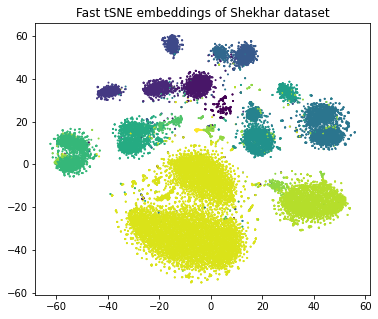

In [27]:
# Clusters Shekhar data
filename_data = 'Datasets/shekhar-cell/data.npy'
filename_gt = 'Datasets/shekhar-cell/clusters.npy'
filename_embeddings = 'Datasets/shekhar-cell/fast_tsne_embeddings.npy'

with open(filename_data, 'rb') as f1:
    shekhar_data = np.load(f1)
with open(filename_gt, 'rb') as f2:
    shekhar_gt = np.load(f2)
with open(filename_embeddings, 'rb') as f3:
    shekhar_embeddings = np.load(f3)

N_shekhar = shekhar_gt.shape[0]
print('Number of examples:', N_shekhar)
K_shekhar = np.unique(shekhar_gt).shape[0]
print('Number of label types:', K_shekhar)
plt.title('Fast tSNE embeddings of Shekhar dataset')
plt.scatter(shekhar_embeddings[:, 0], shekhar_embeddings[:, 1], c=shekhar_gt, s=1)
plt.show()

# Takes subset of 5000 elements
np.random.seed(1)
random_idx = np.random.choice(np.arange(N_shekhar), 5000)
shekhar_subset_X = shekhar_embeddings[random_idx,:]
shekhar_subset_y = shekhar_gt[random_idx]

In [ ]:
D_shekhar = compute_distance_matrix(shekhar_subset_X)
A_shekhar = compute_affinity_matrix(D_shekhar, k=10)

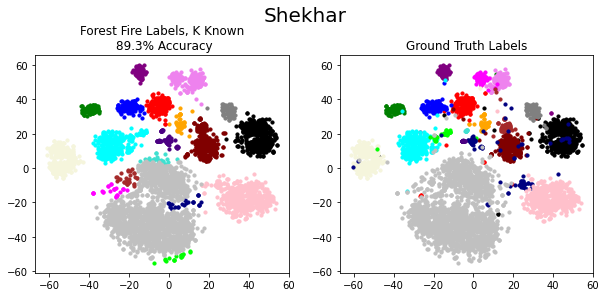

51 clusters are too small; reassigning the 215 points in them. Final model contains 16 clusters.


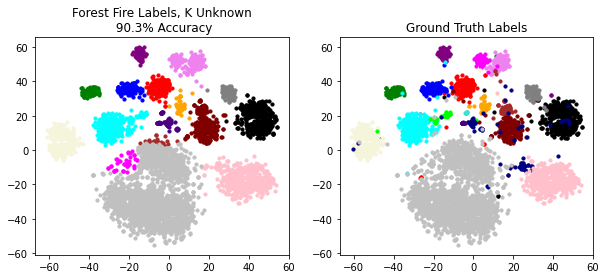

In [29]:
# Scaled, 5000 examples, fire_temp=.5: 82% 
fire_temp_shekhar = 1000
shekhar_labels_known = forest_fire_clustering(A_shekhar, fire_temp_shekhar, k=K_shekhar, n_before_break=100, verbose=True)
shekhar_aligned_known = align_labels(shekhar_subset_y, shekhar_labels_known)
display_outputs_and_gt(shekhar_subset_X, shekhar_subset_y, shekhar_aligned_known, K_shekhar, title='Shekhar', compute_accuracy=True, s=10)

shekhar_labels_unknown = forest_fire_clustering(A_shekhar, fire_temp_shekhar, min_cluster_size=20, removal_threshold=.1, n_before_break=100, verbose=True)
shekhar_aligned_unknown = align_labels(shekhar_subset_y, shekhar_labels_unknown)
display_outputs_and_gt(shekhar_subset_X, shekhar_subset_y, shekhar_aligned_unknown, k_known=False, compute_accuracy=True, s=10)


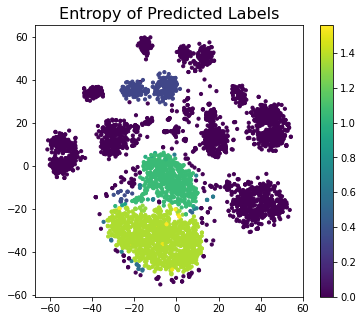

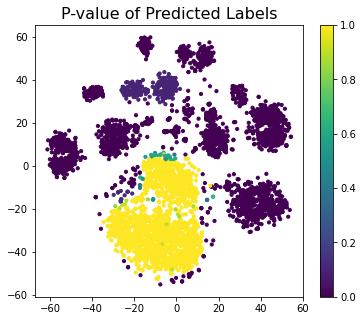

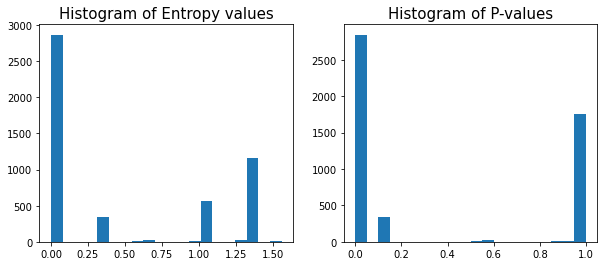

In [10]:
# Measures spread with Monte Carlo verification
monte_carlo_labels_shekhar = monte_carlo_verification(shekhar_aligned_known, A_shekhar, fire_temp_shekhar, num_permute=10)

# Colors/values give uncertainty estimate for each point
e_shekhar = display_entropy(monte_carlo_labels_shekhar, shekhar_subset_X, return_entropy=True)
p_shekhar = display_p_values(monte_carlo_labels_shekhar, shekhar_aligned_known, shekhar_subset_X, return_pvals=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.set_title('Histogram of Entropy values', fontsize=15)
ax1.hist(e_shekhar, bins=20)

ax2.set_title('Histogram of P-values', fontsize=15)
ax2.hist(p_shekhar, bins=20)
plt.show()


Number of examples: 44808
Number of label types: 39


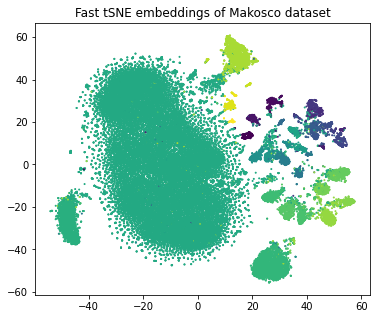

In [43]:
# Clusters Makosco data
filename_data = 'Datasets/makosco-cell/data.npy'
filename_gt = 'Datasets/makosco-cell/clusters.npy'
filename_embeddings = 'Datasets/makosco-cell/fast_tsne_embeddings.npy'

with open(filename_data, 'rb') as f1:
    makosco_data = np.load(f1)
with open(filename_gt, 'rb') as f2:
    makosco_gt = np.load(f2)
with open(filename_embeddings, 'rb') as f3:
    makosco_embeddings = np.load(f3)

N_makosco = makosco_gt.shape[0]
print('Number of examples:', N_makosco)
K_makosco = np.unique(makosco_gt).shape[0]
print('Number of label types:', K_makosco)
plt.title('Fast tSNE embeddings of Makosco dataset')
plt.scatter(makosco_embeddings[:, 0], makosco_embeddings[:, 1], c=makosco_gt, s=1)
plt.show()

# Scales data
# makosco_embeddings = StandardScaler().fit_transform(makosco_embeddings)

np.random.seed(1)
random_idx = np.random.choice(np.arange(N_makosco), 5000)
makosco_subset_X = makosco_embeddings[random_idx,:]
makosco_subset_y = makosco_gt[random_idx]

In [48]:
D_makosco = compute_distance_matrix(makosco_subset_X)
A_makosco = compute_affinity_matrix(D_makosco, k=10)

Inputted that the data has 39 clusters, but our model only burnt 14 clusters.


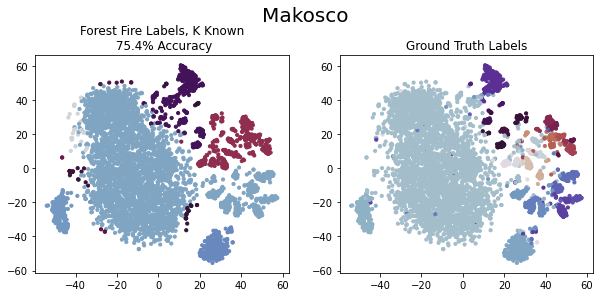

5 clusters are too small; reassigning the 19 points in them. Final model contains 9 clusters.


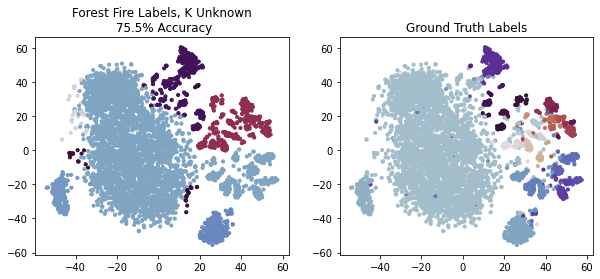

In [49]:
fire_temp_makosco = 1000
# Scaled, 5000 points, fire_temp=.1, 70% accuracy

makosco_labels_known = forest_fire_clustering(A_makosco, fire_temp_makosco, k=K_makosco, n_before_break=200, verbose=True)#, visualization_coords=makosco_subset_X)
makosco_aligned_known = align_labels(makosco_subset_y, makosco_labels_known)
display_outputs_and_gt(makosco_subset_X, makosco_subset_y, makosco_aligned_known, K_makosco, title='Makosco', compute_accuracy=True, s=10)

makosco_labels_unknown = forest_fire_clustering(A_makosco, fire_temp_makosco, min_cluster_size=10, removal_threshold=.1, n_before_break=200, verbose=True)
makosco_aligned_unknown = align_labels(makosco_subset_y, makosco_labels_unknown)
display_outputs_and_gt(makosco_subset_X, makosco_subset_y, makosco_aligned_unknown, k_known=False, compute_accuracy=True, s=10)


In [107]:
def display_both_outputs_and_gt(coords, gt, labels1, labels2, score1=None, score2=None, title=None, compute_accuracy=True,  s=15):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
    if title:
        ttl = fig.suptitle(title, fontsize=20)
        ttl.set_position([.5, 1.1])
        
    text1 = 'Forest Fire Labels, K Known'
    newline = False
    if compute_accuracy:
        N = labels1.shape[0]
        pct_correct = np.sum(labels1 == gt)/N*100
        text1 += '\n %.1f%% Accuracy' % round(pct_correct, 1)
        newline = True
    if score1 is not None:
        text1 += '. ' if newline else '\n'
        text1 += 'Silhouette Score=%.1f' % round(score1, 2)
    
    text2 = 'Forest Fire Labels, K Unknown'
    newline = False
    if compute_accuracy:
        N = labels2.shape[0]
        pct_correct = np.sum(labels2 == gt)/N*100
        text2 += '\n %.1f%% Accuracy' % round(pct_correct, 1)
        newline = True
    if score2 is not None:
        text2 += '. ' if newline else '\n'
        text2 += 'Silhouette Score=%.2f' % round(score2, 2)
    
    cdict = {0: 'orange', 1: 'red', 2: 'blue', 3: 'green',
             4: 'purple', 5: 'violet', 6: 'magenta', 7: 'black',
             8: 'brown', 9: 'maroon', 10: 'gray', 11: 'cyan',
             12: 'beige', 13: 'lime', 14: 'turquoise', 15: 'navy',
             16: 'pink', 17: 'silver', 18: 'indigo', 19: 'tan'}
    k_model1 = np.unique(labels1).shape[0]
    k_model2 = np.unique(labels2).shape[0]
    k_gt = np.unique(gt).shape[0]
    max_n_clusters = max(k_model1, k_model2, k_gt)
    if max_n_clusters < len(cdict.keys()):
        for g in range(max_n_clusters):
            ix1 = np.where(labels1 == g)
            ax1.scatter(coords[ix1,0], coords[ix1,1], c=cdict[g], label=g, s=s)
            
            ix2 = np.where(labels2 == g)
            ax2.scatter(coords[ix2,0], coords[ix2,1], c=cdict[g], label=g, s=s)

            ix3 = np.where(gt == g)
            ax3.scatter(coords[ix3,0], coords[ix3,1], c=cdict[g], label=g, s=s)
    else:
        ax1.scatter(coords[:,0], coords[:,1], c=labels1, cmap='twilight_shifted_r', s=s)
        ax2.scatter(coords[:,0], coords[:,1], c=labels2, cmap='twilight_shifted_r', s=s)
        ax3.scatter(coords[:,0], coords[:,1], c=gt, cmap='twilight_shifted_r', s=s)
    
    ax1.set_title(text1)
    ax2.set_title(text2)
    ax3.set_title('Ground Truth Labels')
    plt.show()    

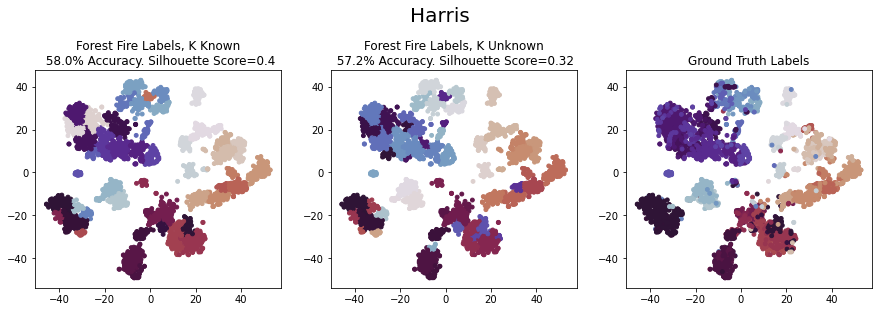

In [110]:
score_known = silhouette_score(D_harris, harris_aligned_known)
score_unknown = silhouette_score(D_harris, harris_aligned_unknown)
display_both_outputs_and_gt(harris_embeddings, gt=harris_gt, labels1=harris_aligned_known, labels2=harris_aligned_unknown, score1=score_known, score2=score_unknown, title='Harris', compute_accuracy=True, s=15)


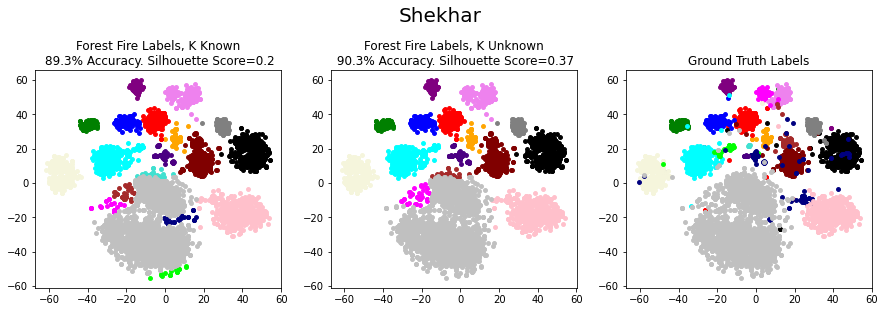

In [108]:
score_known = silhouette_score(D_shekhar, shekhar_aligned_known)
score_unknown = silhouette_score(D_shekhar, shekhar_aligned_unknown)
display_both_outputs_and_gt(shekhar_subset_X, gt=shekhar_subset_y, labels1=shekhar_aligned_known, labels2=shekhar_aligned_unknown, score1=score_known, score2=score_unknown, title='Shekhar', compute_accuracy=True, s=15)


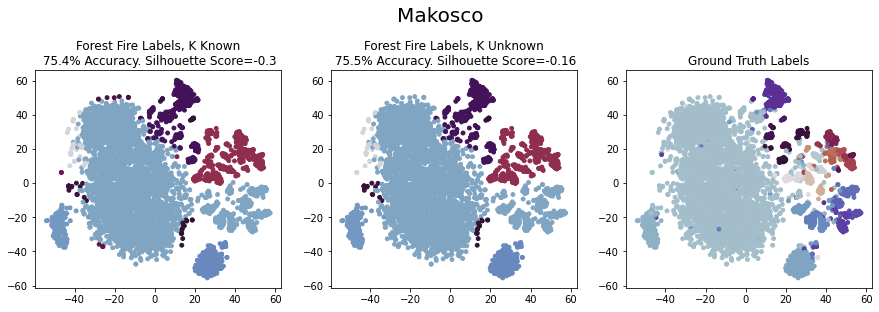

In [111]:
score_known = silhouette_score(D_makosco, makosco_aligned_known)
score_unknown = silhouette_score(D_makosco, makosco_aligned_unknown)
display_both_outputs_and_gt(makosco_subset_X, gt=makosco_subset_y, labels1=makosco_aligned_known, labels2=makosco_aligned_unknown, score1=score_known, score2=score_unknown, title='Makosco', compute_accuracy=True, s=15)
